## unificar datos de absorbancia – AOxMM

En esta celda convertimos todos los archivos `.txt` con datos de absorbancia de muestras de café de Oaxaca - AOxMM (molienda mini) a una sola matriz `.csv`, lista para analizar.

Cada archivo `.txt` contiene una columna con longitudes de onda y otra con absorbancia. Lo que hacemos es:

- Detectar todos los archivos `.txt` en la carpeta actual
- Ordenarlos por gramaje (extraído del nombre del archivo, como AOxMM05, AOxMM20, etc.)
- Leer y limpiar cada archivo (`NaN` si hay valores no numéricos)
- Nombrar cada columna según el archivo
- Unir todo en una sola tabla donde:
  - Las filas son longitudes de onda (`nm`)
  - Las columnas son las distintas muestras

El resultado se guarda en un archivo llamado `AOxMM_matrix.csv`


In [2]:
import pandas as pd
import os
import re

# Detectamos los archivos .txt válidos (los que tienen datos de absorbancia)
archivos_txt = [f for f in os.listdir() if f.endswith('.txt') and f != 'AOxMM.csv']

# Función para extraer gramaje del nombre del archivo
def extraer_gramos(nombre):
    match = re.search(r'(\d+_?\d*)g', nombre)
    if match:
        return float(match.group(1).replace('_', '.'))
    return float('inf')

# Ordenamos los archivos por gramaje (más limpio para visualizar después)
archivos_ordenados = sorted(archivos_txt, key=extraer_gramos)

# Leemos y procesamos los archivos
dataframes = []
for archivo in archivos_ordenados:
    df = pd.read_csv(archivo, sep=None, engine='python')  # autodetecta separador
    df = df[pd.to_numeric(df.iloc[:, 0], errors='coerce').notna()]
    
    nombre_columna = os.path.splitext(archivo)[0]
    df.columns = ['nm', nombre_columna]
    df[nombre_columna] = pd.to_numeric(df[nombre_columna], errors='coerce')
    dataframes.append(df)

# Unimos los datos por la columna de longitud de onda
df_consolidado = dataframes[0]
for df in dataframes[1:]:
    df_consolidado = pd.merge(df_consolidado, df, on='nm', how='outer')

# Guardamos el archivo final
df_consolidado.to_csv('AOxMM_matrix.csv', index=False)

print("Archivo 'AOxMM_matrix.csv' creado con éxito")


Archivo 'AOxMM_matrix.csv' creado con éxito


## verificamos la matriz de datos

Una vez que ya unimos todos los datos en el archivo `AOxMM_matrix.csv`, ahora toca revisarlos para entender su forma.

Usamos dos funciones de la librería `pandas`: 

- `head()` para ver las primeras filas y verificar que las columnas se hayan unido bien
- `info()` para saber cuántos datos tiene cada muestra y cuántos valores faltantes hay (`NaN`)

In [3]:
import pandas as pd
datos = pd.read_csv("AOxMM_matrix.csv")

In [4]:
datos.head()

,nm,AOxMM05,AOxMM,AOxMM50,AOxMM20
0,200.0,NaN,NaN,NaN,NaN
1,200.5,NaN,NaN,NaN,NaN
2,201.0,NaN,NaN,NaN,NaN
3,201.5,NaN,NaN,NaN,NaN
4,202.0,NaN,NaN,NaN,NaN


Vemos que:


- Donde no hay medición, aparece un `NaN`

In [6]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   nm       421 non-null    float64
 1   AOxMM05  405 non-null    float64
 2   AOxMM    375 non-null    float64
 3   AOxMM50  363 non-null    float64
 4   AOxMM20  370 non-null    float64
dtypes: float64(5)
memory usage: 16.6 KB


- Hay **421 longitudes de onda (filas)**.
- Algunas muestras tienen más datos que otras (por ejemplo, AOxMM05 tiene 405 valores válidos, mientras que AOxMM50  tiene 363).

## Graficamos las curvas de absorbancia ordenadas por intensidad

Ya con la matriz de datos limpia (valores NaN donde hubo saturación), graficamos las curvas de absorbancia de las muestras de café de Oaxaca

Pasos:
- Limpiamos valores fuera de rango (absorbancias > 10)
- Calculamos el valor máximo de absorbancia para cada muestra
- Reordenamos las columnas según ese valor
- Y finalmente, graficamos todas las curvas con `matplotlib`

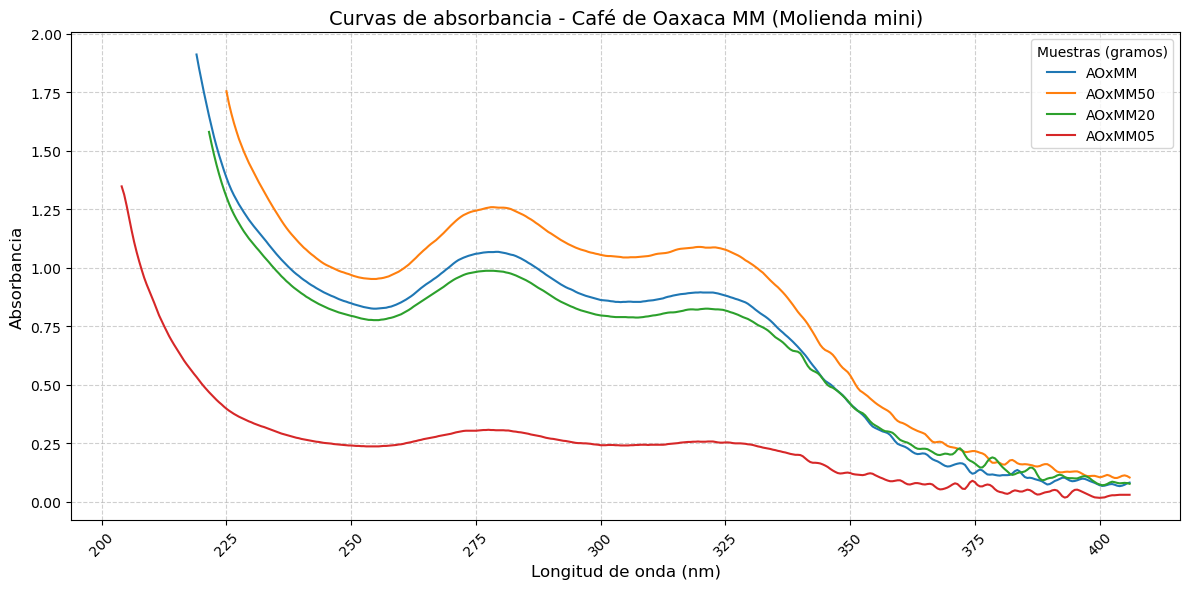

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargamos el archivo con las mediciones de absorbancia unidas en una matriz de datos
df = pd.read_csv("AOxMM_matrix.csv")

# Limpiamos datos fuera de rango (>10)
for columna in df.columns[1:]:
    df[columna] = pd.to_numeric(df[columna], errors='coerce')
    df.loc[df[columna] > 10, columna] = None

# Obtenemos los valores máximos de cada curva
maximos = {
    columna: df[columna].max(skipna=True)
    for columna in df.columns[1:]
}

# Ordenamos de mayor a menor para que la leyenda coincida con las curvas
columnas_ordenadas = sorted(maximos, key=maximos.get, reverse=True)

# Creamos figura
plt.figure(figsize=(12, 6))

# Dibujamos las curvas ya ordenadas
for columna in columnas_ordenadas:
    plt.plot(df['nm'], df[columna], label=columna)

# Etiquetas y estilo
plt.xlabel('Longitud de onda (nm)', fontsize=12)
plt.ylabel('Absorbancia', fontsize=12)
plt.title('Curvas de absorbancia - Café de Oaxaca MM (Molienda mini)', fontsize=14)
plt.legend(title='Muestras (gramos)', fontsize=10)
plt.xticks(df['nm'][::50], rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Graficamos las curvas suavizadas y ordenadas por intensidad

A partir de la matriz de datos y limpia (NaN), ahora generamos una gráfica más estética y legible aplicando suavizado:

- Usamos `savgol_filter` (filtro de savitzky-golay) para suavizar las curvas
- Calculamos el valor máximo de cada curva suavizada
- Reordenamos las muestras de mayor a menor según ese pico
- Finalmente, graficamos con `seaborn` y `matplotlib`, usando una paleta amigable y una cuadrícula para facilitar la lectura

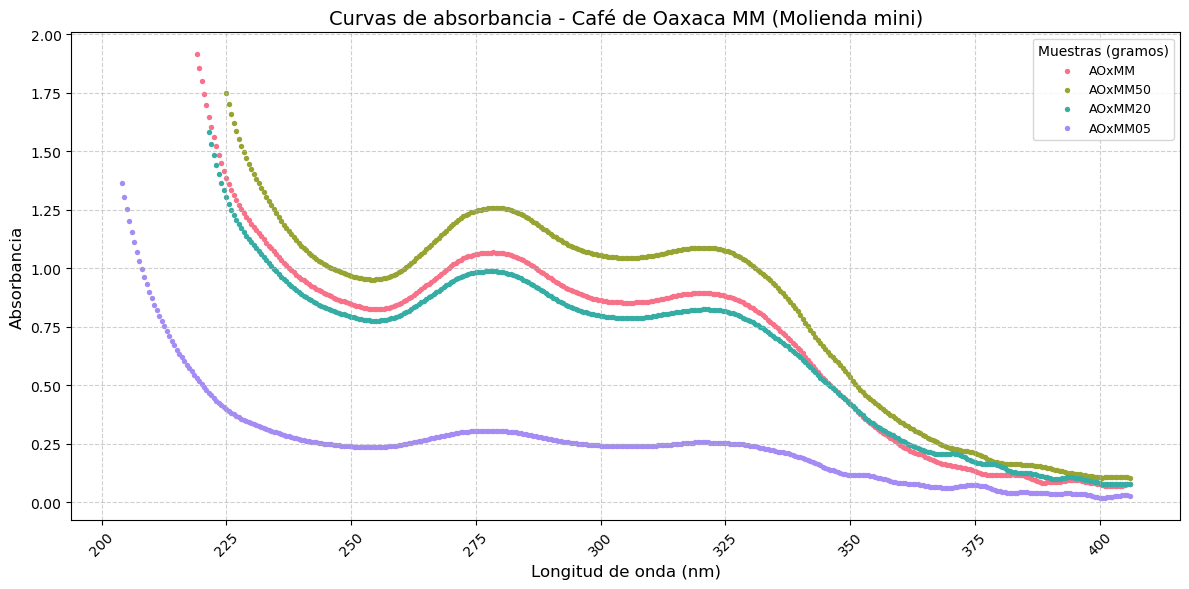

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sb
import numpy as np

# Cargamos la matriz de datos con las mediciones de absorbancia unidas 
df = pd.read_csv("AOxMM_matrix.csv")

# Convertimos valores y descartamos saturación
for columna in df.columns[1:]:
    df[columna] = pd.to_numeric(df[columna], errors='coerce')
    df.loc[df[columna] > 10, columna] = None

# Obtenemos máximos de las curvas suavizadas
max_absorbancias = {}

for columna in df.columns[1:]:
    datos_validos = df[columna].dropna()
    if len(datos_validos) >= 21:
        y_suave = savgol_filter(datos_validos, window_length=21, polyorder=3)
        max_absorbancias[columna] = np.max(y_suave)
    else:
        max_absorbancias[columna] = -np.inf  # Muy bajo para que quede al final

# Ordenamos columnas por su valor máximo suavizado
columnas_ordenadas = sorted(max_absorbancias, key=max_absorbancias.get, reverse=True)

# Paleta de color amigable
colores = sb.color_palette("husl", len(columnas_ordenadas))

# Figura
plt.figure(figsize=(12, 6))

# Graficamos suavizado por muestra, en orden 
for i, columna in enumerate(columnas_ordenadas):
    datos_validos = df[columna].dropna()
    if len(datos_validos) >= 21:
        y_suave = savgol_filter(datos_validos, window_length=21, polyorder=3)
        x_vals = df['nm'][datos_validos.index]
        sb.scatterplot(x=x_vals, y=y_suave, s=15, label=columna, color=colores[i], linewidth=0)
    else:
        plt.plot(df['nm'], df[columna], label=columna, color=colores[i], linestyle='--')

# Estética
plt.xlabel('Longitud de onda (nm)', fontsize=12)
plt.ylabel('Absorbancia', fontsize=12)
plt.title('Curvas de absorbancia - Café de Oaxaca MM (Molienda mini)', fontsize=14)
plt.legend(title='Muestras (gramos)', fontsize=9)
plt.xticks(df['nm'][::50], rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Suavizado con curvas con gradiente

Usamos ahora en este caso un gradiente de color que refleja la intensidad

- Quitamos valores saturados (>10)
- Suavizamos las curvas (si hay datos suficientes)
- Ordenamos por intensidad máxima
- Dibujamos: si la curva está completa, va con gradiente; si no, con línea punteada

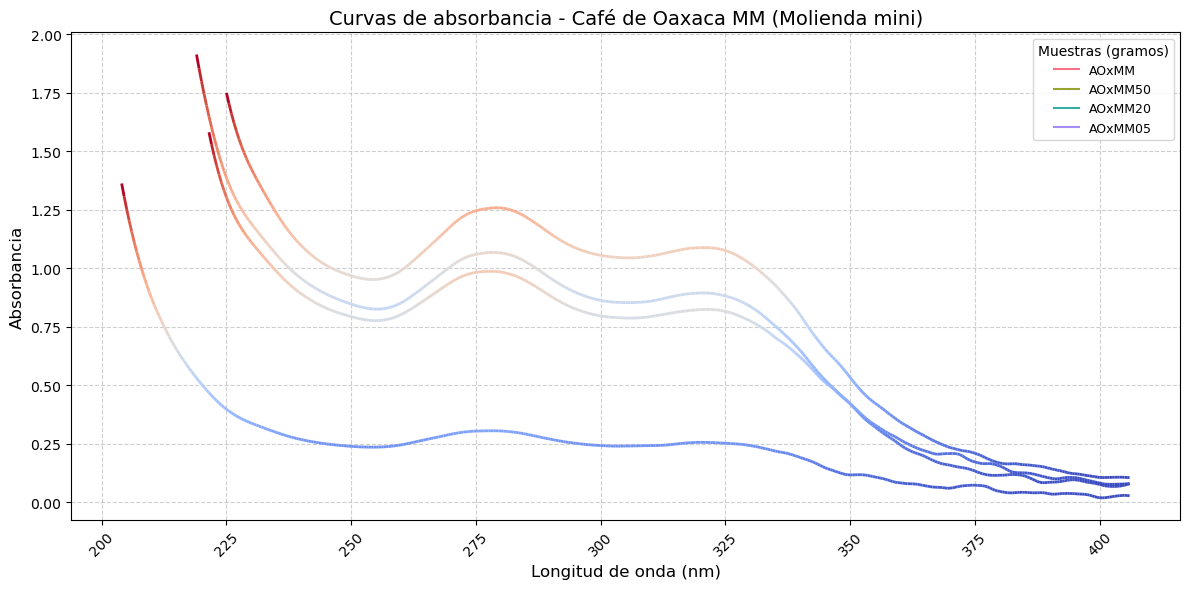

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import seaborn as sb
import numpy as np

# Cargamos la matriz de datos con las mediciones de absorbancia unidas 
df = pd.read_csv("AOxMM_matrix.csv")

# Procesamos columnas de absorbancia (excepto 'nm')
for columna in df.columns[1:]:
    df[columna] = pd.to_numeric(df[columna], errors='coerce')
    df.loc[df[columna] > 10, columna] = None

# Diccionario para guardar valores máximos de cada curva suavizada
max_absorbancias = {}

# Calculamos máximos de cada columna suavizable
for columna in df.columns[1:]:
    datos_validos = df[columna].dropna()
    if len(datos_validos) >= 21:
        y_suave = savgol_filter(datos_validos, window_length=21, polyorder=3)
        max_absorbancias[columna] = np.max(y_suave)
    else:
        max_absorbancias[columna] = np.nan  # O podemos usar max original

# Ordenamos columnas por valor máximo descendente
columnas_ordenadas = sorted(max_absorbancias, key=max_absorbancias.get, reverse=True)

# Figura principal
plt.figure(figsize=(12, 6))
plt.title("Curvas de absorbancia - Café de Oaxaca MM (Molienda mini)", fontsize=14)

# Paleta para los colores
colores_base = sb.color_palette("husl", len(columnas_ordenadas))

# Plot
for i, columna in enumerate(columnas_ordenadas):
    datos_validos = df[['nm', columna]].dropna()

    if len(datos_validos) >= 21:
        y_suave = savgol_filter(datos_validos[columna], window_length=21, polyorder=3)
        x = datos_validos['nm'].values
        y = y_suave

        puntos = np.array([x, y]).T.reshape(-1, 1, 2)
        segmentos = np.concatenate([puntos[:-1], puntos[1:]], axis=1)

        norm = mcolors.Normalize(vmin=np.min(y), vmax=np.max(y))
        lc = LineCollection(segmentos, cmap='coolwarm', norm=norm)
        lc.set_array(y)
        lc.set_linewidth(2.0)
        plt.gca().add_collection(lc)

        plt.plot([], [], color=colores_base[i], label=columna)
    else:
        plt.plot(df['nm'], df[columna], linestyle='--', color=colores_base[i], label=columna)

# Ejes y estética
plt.xlabel("Longitud de onda (nm)", fontsize=12)
plt.ylabel("Absorbancia", fontsize=12)
plt.legend(title="Muestras (gramos)", fontsize=9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(df['nm'][::50], rotation=45)
plt.tight_layout()
plt.show()